# Introduction

In this project, you'll label the pixels of a road in images using a Fully Convolutional Network (FCN).

In [1]:
import os.path
import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests
import sys
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Dataset

## Kitti Road dataset

You can download the dataset from [here](http://www.cvlibs.net/download.php?file=data_road.zip).

The dataset contains a labelled training set and a test set. 

The label is `(road, not road)` for each pixel.

The dimension of images in this dataset is (375, 1242)

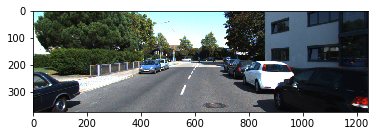

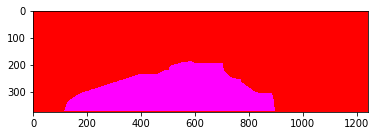

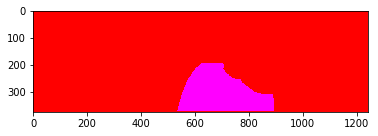

In [2]:
kitti_data_path = os.path.join('.', 'data', 'data_road', 'training')

img=mpimg.imread(os.path.join(kitti_data_path, "image_2", "um_000004.png"))
img_label_road=mpimg.imread(os.path.join(kitti_data_path, "gt_image_2", "um_road_000004.png"))
img_label_lane=mpimg.imread(os.path.join(kitti_data_path, "gt_image_2", "um_lane_000004.png"))

plt.imshow(img)
plt.show()

plt.imshow(img_label_road)
plt.show()

plt.imshow(img_label_lane)
plt.show()

## City scaper dataset

The dataset required registration to have access to the dataset. You can see the homepage of cityscaper dataset from [here](https://www.cityscapes-dataset.com/)

The following datasets is used in this project :

1. `leftImg8bit` - Original Image (2975 training, 500 validation, and 1525 testing.)
2. `gtFine` - Fine annotation label (2975 training, 500 validation, and 1525 testing.)

There exists a coarse annotation dataset (`gtCoarse`) containing 19998 training, but this is not used in this project.

The dimension of images in this dataset is (1024, 2048)

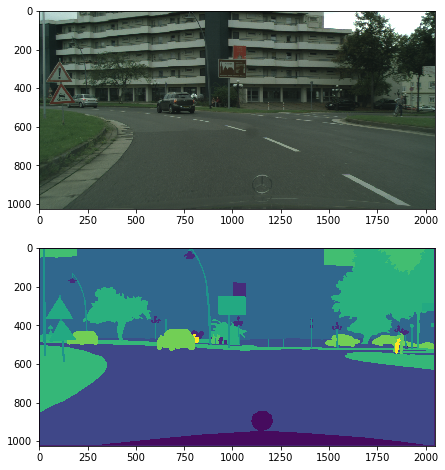

In [3]:
cityscapes_data_path = os.path.join('.', 'data', 'cityscapes')

img_path=os.path.join(cityscapes_data_path, "leftImg8bit", "train", "aachen", "aachen_000000_000019_leftImg8bit.png")
img_label_path = os.path.join(cityscapes_data_path, "gtFine", "train", "aachen", "aachen_000000_000019_gtFine_labelIds.png")

img=mpimg.imread(img_path)
img_label=mpimg.imread(img_label_path)

f, axarr = plt.subplots(2, figsize=(8,8))

axarr[0].imshow(img)
axarr[1].imshow(img_label)

plt.show()

### Label of city scaper dataset

| Name  | Category ID   | Name  | Category ID   |
|---|---|---|---|
|unlabeled   |0   |polegroup   |18   |
|ego vehicle   |1   |traffic light   |19   |
|rectification border   |2   |traffic sign   |20  |
|out of roi   |3   |vegetation   |21 |
|static   |4   |terrain   |22 |
|dynamic   |5   |sky   |23  |
|ground   |6   |person   |24   |
|road   |7   |rider   |25   |
|sidewalk   |8   |car   |26   |
|parking   |9   |truck   |27   |
|rail track   |10   |bus   |28   |
|building   |11  |caravan   |29   |
|wall   |12   |trailer   |30   |
|fence   |13   |train   |31   |
|guard rail   |14   |motorcycle   |32   |
|bridge   |15   |bicycle   |33   |
|tunnel   |16   |license plate   |-1   |
|pole   |17   | | |


















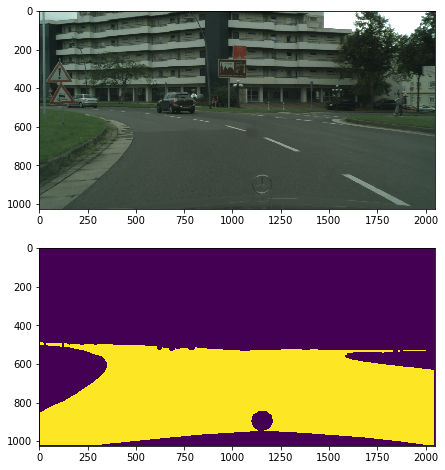

In [4]:
from PIL import Image
import numpy as np

img_label = np.asarray(Image.open(img_label_path))
img_label_road = img_label==7

f, axarr = plt.subplots(2, figsize=(8,8))

axarr[0].imshow(img)
axarr[1].imshow(img_label_road)

plt.show()

### Corp sky scaper iamge for FCN input

C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


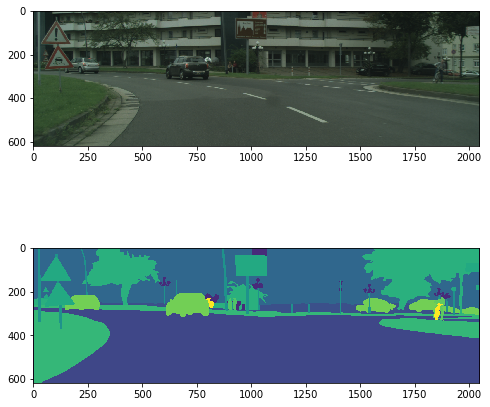

In [5]:
import scipy.misc

cityscpaes_roi = (216, 0, 834, 2048)

def corp_cityscapes_roi(image, roi):
    if len(image.shape) == 3:
        return image[cityscpaes_roi[0]:cityscpaes_roi[2], cityscpaes_roi[1]:cityscpaes_roi[3], :]
    else:
        return image[cityscpaes_roi[0]:cityscpaes_roi[2], cityscpaes_roi[1]:cityscpaes_roi[3]]
    
image = scipy.misc.imread(img_path)
image_corp = corp_cityscapes_roi(image, cityscpaes_roi)

gt_image = scipy.misc.imread(img_label_path)
gt_image_corp = corp_cityscapes_roi(gt_image, cityscpaes_roi)

f, axarr = plt.subplots(2, figsize=(8,8))

axarr[0].imshow(image_corp)
axarr[1].imshow(gt_image_corp)

plt.show()

# FCN-VGG16 implementation

Please refer to [this paper](https://arxiv.org/pdf/1411.4038.pdf) for detail.

### Create a new batch generator to take from both dataset

In [6]:
def apply_random_shadow(image):
    #
    # Add a random shadow to a BGR image to pretend
    # we've got clouds or other interference on the road.
    #
    rows, cols, _ = image.shape
    top_y = cols * np.random.uniform()
    top_x = 0
    bot_x = rows
    bot_y = cols * np.random.uniform()
    image_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    shadow_mask = 0 * image_hls[:, :, 1]
    X_m = np.mgrid[0:image.shape[0], 0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0], 0:image.shape[1]][1]
    shadow_mask[((X_m - top_x) * (bot_y - top_y) - (bot_x - top_x) * (Y_m - top_y) >= 0)] = 1

    if np.random.randint(2) == 1:
        random_bright = .5
        cond1 = (shadow_mask == 1)
        cond0 = (shadow_mask == 0)
        if np.random.randint(2) == 1:
            image_hls[:, :, 1][cond1] = image_hls[:, :, 1][cond1] * random_bright
        else:
            image_hls[:, :, 1][cond0] = image_hls[:, :, 1][cond0] * random_bright

    image = cv2.cvtColor(image_hls, cv2.COLOR_HLS2RGB)
    return image


def apply_brightness_augmentation(image):
    #
    # expects input image as BGR, adjusts brightness to
    # pretend we're in different lighting conditions.
    #
    image1 = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_bright = .25 + np.random.uniform()
    image1[:, :, 2] = image1[:, :, 2] * random_bright
    image2 = cv2.cvtColor(image1, cv2.COLOR_HSV2RGB)
    return image2


def apply_translation(image, label, translation_range):
    #
    # Shift image up or down a bit within trans_range pixels,
    # filling missing area with black.  IMG is in BGR format.
    #
    rows, cols, _ = image.shape
    tr_x = translation_range * np.random.uniform() - translation_range / 2
    tr_y = 10 * np.random.uniform() - 10 / 2
    trans_m = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
    img_tr = cv2.warpAffine(image, trans_m, (cols, rows))
    label_tr = cv2.warpAffine(label, trans_m, (cols, rows))
    return img_tr, label_tr


def augment(image_raw, label):
    img = apply_brightness_augmentation(image_raw)

    if np.random.randint(4) == 0:
        img_shadows = apply_random_shadow(img)
    else:
        img_shadows = img

    if np.random.randint(2) == 0:
        img_trans, label_trans = apply_translation(img_shadows, label, 25)
    else:
        img_trans, label_trans = img_shadows, label

    if np.random.randint(4) == 0:
        img_flip = cv2.flip(img_trans, 1)
        label_flip = cv2.flip(label_trans, 1)
    else:
        img_flip, label_flip = img_trans, label_trans

    return img_flip, label_flip

In [7]:
from glob import glob
import re
import random

kitti_data_folder = kitti_data_path
cityscapes_data_folder = cityscapes_data_path
image_shape = (160, 576)

def get_label_kitti(gt_image, background_color):
    gt_bg = np.all(gt_image == background_color, axis=2)
    gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
    gt_bg = gt_bg.astype(np.uint8)
    gt_bg = 1-gt_bg
    return gt_bg

def get_label_cityscapes(gt_image, road_label):
    gt_bg = (gt_image == road_label)
    gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
    gt_bg = gt_bg.astype(np.uint8)
    return gt_bg

def get_batches_fn(batch_size):
    """
    Create batches of training data
    :param batch_size: Batch Size
    :return: Batches of training data
    """
    image_paths_kitti = glob(os.path.join(kitti_data_folder, 'image_2', '*.png'))
    label_paths_kitti = {
        re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
        for path in glob(os.path.join(kitti_data_folder, 'gt_image_2', '*_road_*.png'))}
    
    image_paths_cityscapes = glob(os.path.join(cityscapes_data_folder, 'leftImg8bit', 'train', '**', '*_leftImg8bit.png'))
    label_paths_cityscapes = {
        re.sub(r'_gtFine_labelIds.png', '_leftImg8bit.png', os.path.basename(path)): path
        for path in glob(os.path.join(cityscapes_data_folder, 'gtFine', 'train', '**', '*_gtFine_labelIds.png'))}
    
    #print('Debug ' + os.path.join(cityscapes_data_folder, 'leftImg8bit', 'train', '**', '_leftImg8bit.png'))
    #print('Debug ' + str(len(image_paths_cityscapes)))
    
    background_color_kitti = np.array([255, 0, 0])
    road_label_cityscaper = 7
    
    image_paths = image_paths_kitti + image_paths_cityscapes

    random.shuffle(image_paths)
    for batch_i in range(0, len(image_paths), batch_size):
        images = []
        gt_images = []
        for image_file in image_paths[batch_i:batch_i+batch_size]:
            print('Debug: ' + image_file)
            
            gt_image_file = label_paths_cityscapes.get(os.path.basename(image_file), None)
            
            if gt_image_file is not None:
                image = scipy.misc.imresize(corp_cityscapes_roi(scipy.misc.imread(image_file), cityscpaes_roi), image_shape)
                gt_image = scipy.misc.imresize(corp_cityscapes_roi(scipy.misc.imread(gt_image_file), cityscpaes_roi), image_shape)
                gt_bg = get_label_cityscapes(gt_image, road_label_cityscaper)
            else:
                gt_image_file = label_paths_kitti[os.path.basename(image_file)]
                image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)
                gt_image = scipy.misc.imresize(scipy.misc.imread(gt_image_file), image_shape)
                gt_bg = get_label_kitti(gt_image, background_color_kitti)
            
            image_a, gt_road_a = augment(image, gt_bg)
            gt_road_a = np.atleast_3d(gt_road_a)
                
            gt_image = np.concatenate(((gt_road_a==0).astype(np.uint8), gt_road_a), axis=2)

            images.append(image_a)
            gt_images.append(gt_image)

        yield np.array(images), np.array(gt_images)

Debug: .\data\cityscapes\leftImg8bit\train\ulm\ulm_000003_000019_leftImg8bit.png


C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:56: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:57: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:57: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Debug: .\data\cityscapes\leftImg8bit\train\stuttgart\stuttgart_000165_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\cologne\cologne_000115_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\hamburg\hamburg_000000_089696_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\hanover\hanover_000000_011170_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\aachen\aachen_000085_000019_leftImg8bit.png
Debug: .\data\data_road\training\image_2\uu_000014.png


C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:61: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:61: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:62: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:62: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Debug: .\data\cityscapes\leftImg8bit\train\krefeld\krefeld_000000_018004_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\hanover\hanover_000000_019938_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\aachen\aachen_000154_000019_leftImg8bit.png


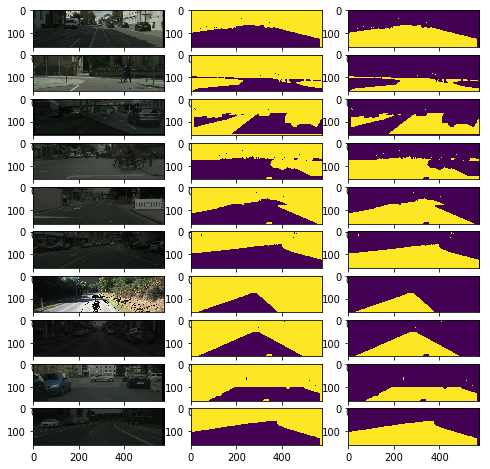

Debug: .\data\cityscapes\leftImg8bit\train\tubingen\tubingen_000013_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\strasbourg\strasbourg_000001_032315_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\stuttgart\stuttgart_000183_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\krefeld\krefeld_000000_015868_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\cologne\cologne_000101_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\stuttgart\stuttgart_000171_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\strasbourg\strasbourg_000001_039558_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\darmstadt\darmstadt_000028_000019_leftImg8bit.png
Debug: .\data\data_road\training\image_2\umm_000087.png
Debug: .\data\cityscapes\leftImg8bit\train\erfurt\erfurt_000065_000019_leftImg8bit.png


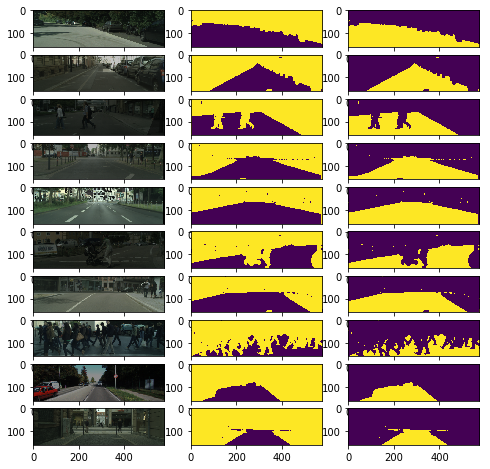

Debug: .\data\cityscapes\leftImg8bit\train\darmstadt\darmstadt_000004_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\bremen\bremen_000082_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\strasbourg\strasbourg_000001_061384_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\strasbourg\strasbourg_000001_018742_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\aachen\aachen_000109_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\hamburg\hamburg_000000_021353_leftImg8bit.png
Debug: .\data\data_road\training\image_2\umm_000035.png
Debug: .\data\cityscapes\leftImg8bit\train\aachen\aachen_000064_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\aachen\aachen_000004_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\strasbourg\strasbourg_000001_032660_leftImg8bit.png


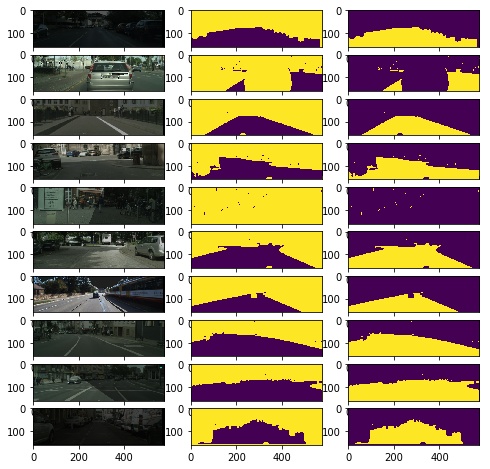

Debug: .\data\cityscapes\leftImg8bit\train\weimar\weimar_000131_000019_leftImg8bit.png
Debug: .\data\data_road\training\image_2\um_000083.png
Debug: .\data\cityscapes\leftImg8bit\train\krefeld\krefeld_000000_030111_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\strasbourg\strasbourg_000001_014258_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\bremen\bremen_000244_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\darmstadt\darmstadt_000009_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\hamburg\hamburg_000000_065843_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\ulm\ulm_000057_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\tubingen\tubingen_000059_000019_leftImg8bit.png
Debug: .\data\data_road\training\image_2\uu_000083.png


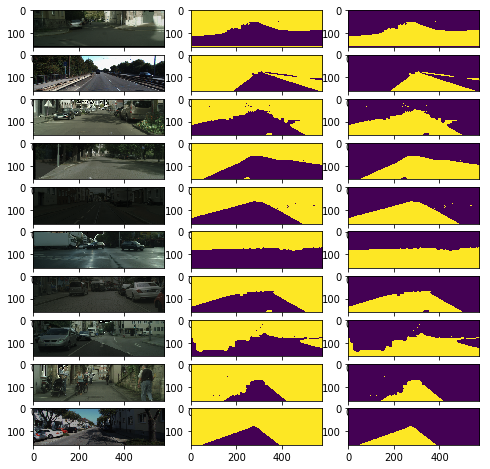

Debug: .\data\cityscapes\leftImg8bit\train\bochum\bochum_000000_022210_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\tubingen\tubingen_000042_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\stuttgart\stuttgart_000174_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\strasbourg\strasbourg_000001_018432_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\bremen\bremen_000136_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\cologne\cologne_000059_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\bochum\bochum_000000_014658_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\tubingen\tubingen_000106_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\strasbourg\strasbourg_000000_021231_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\strasbourg\strasbourg_000000_021651_leftImg8bit.png


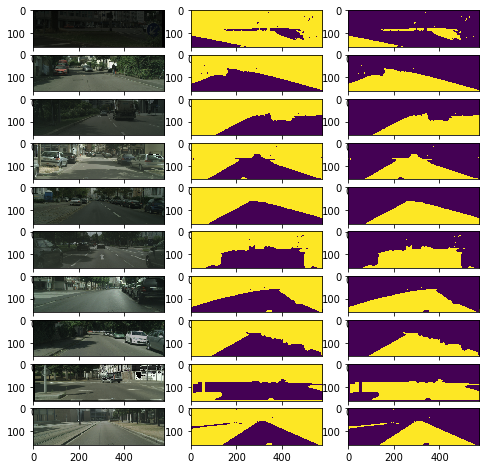

Debug: .\data\cityscapes\leftImg8bit\train\weimar\weimar_000008_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\strasbourg\strasbourg_000001_000710_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\aachen\aachen_000143_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\hamburg\hamburg_000000_066988_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\bochum\bochum_000000_008162_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\ulm\ulm_000085_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\stuttgart\stuttgart_000178_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\tubingen\tubingen_000126_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\cologne\cologne_000089_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\bremen\bremen_000107_000019_leftImg8bit.png


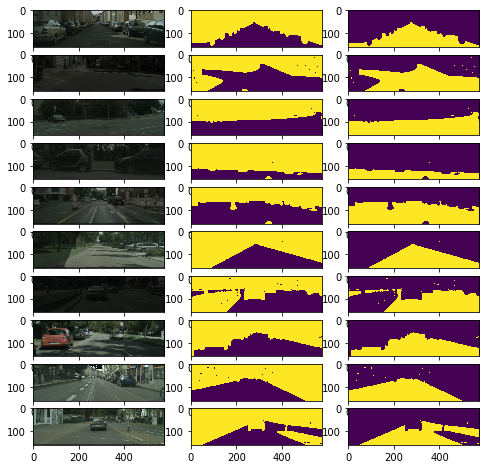

Debug: .\data\cityscapes\leftImg8bit\train\weimar\weimar_000106_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\monchengladbach\monchengladbach_000000_023375_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\stuttgart\stuttgart_000028_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\hamburg\hamburg_000000_016447_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\cologne\cologne_000136_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\strasbourg\strasbourg_000001_052198_leftImg8bit.png
Debug: .\data\data_road\training\image_2\um_000006.png
Debug: .\data\cityscapes\leftImg8bit\train\aachen\aachen_000128_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\monchengladbach\monchengladbach_000001_000054_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\erfurt\erfurt_000084_000019_leftImg8bit.png


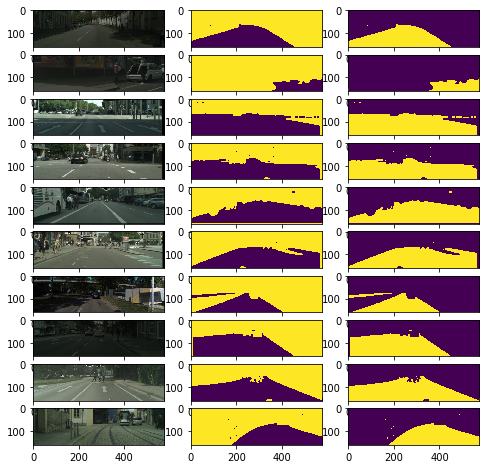

Debug: .\data\cityscapes\leftImg8bit\train\bochum\bochum_000000_022414_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\aachen\aachen_000010_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\darmstadt\darmstadt_000040_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\strasbourg\strasbourg_000001_030839_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\strasbourg\strasbourg_000000_017593_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\cologne\cologne_000094_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\stuttgart\stuttgart_000182_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\cologne\cologne_000075_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\darmstadt\darmstadt_000046_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\strasbourg\strasbourg_000001_040564_leftImg8bit.png


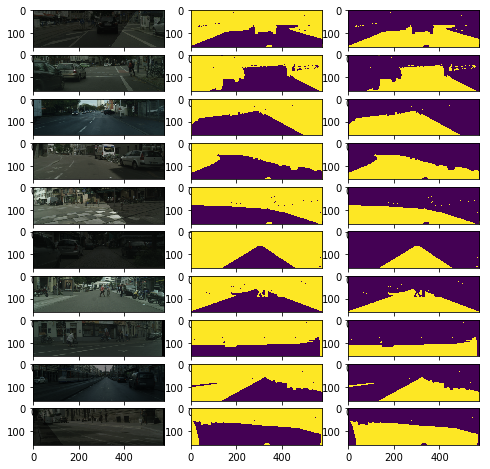

Debug: .\data\cityscapes\leftImg8bit\train\bremen\bremen_000150_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\zurich\zurich_000036_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\bochum\bochum_000000_001519_leftImg8bit.png
Debug: .\data\data_road\training\image_2\um_000015.png
Debug: .\data\cityscapes\leftImg8bit\train\hamburg\hamburg_000000_042505_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\krefeld\krefeld_000000_025434_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\zurich\zurich_000070_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\dusseldorf\dusseldorf_000121_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\erfurt\erfurt_000085_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\stuttgart\stuttgart_000076_000019_leftImg8bit.png


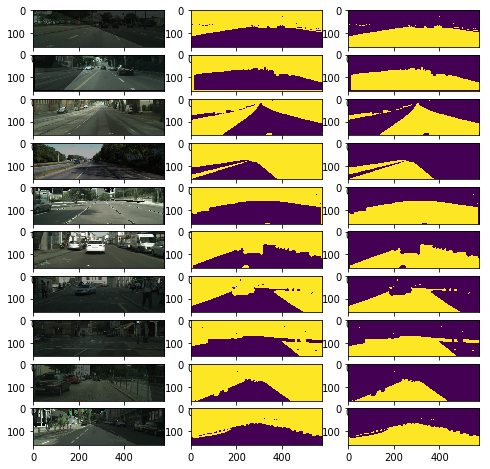

Debug: .\data\data_road\training\image_2\uu_000084.png
Debug: .\data\cityscapes\leftImg8bit\train\dusseldorf\dusseldorf_000081_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\bremen\bremen_000028_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\zurich\zurich_000109_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\bremen\bremen_000162_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\jena\jena_000109_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\hamburg\hamburg_000000_036427_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\bremen\bremen_000224_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\bremen\bremen_000072_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\krefeld\krefeld_000000_009574_leftImg8bit.png


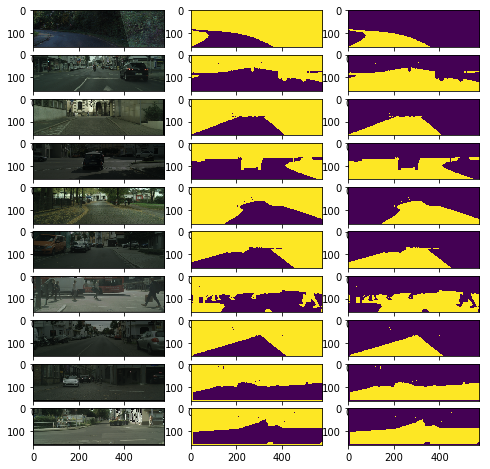

Debug: .\data\cityscapes\leftImg8bit\train\krefeld\krefeld_000000_006274_leftImg8bit.png
Debug: .\data\data_road\training\image_2\umm_000088.png
Debug: .\data\cityscapes\leftImg8bit\train\bremen\bremen_000283_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\tubingen\tubingen_000127_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\weimar\weimar_000137_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\tubingen\tubingen_000047_000019_leftImg8bit.png
Debug: .\data\data_road\training\image_2\umm_000017.png
Debug: .\data\cityscapes\leftImg8bit\train\aachen\aachen_000151_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\bremen\bremen_000070_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\tubingen\tubingen_000040_000019_leftImg8bit.png


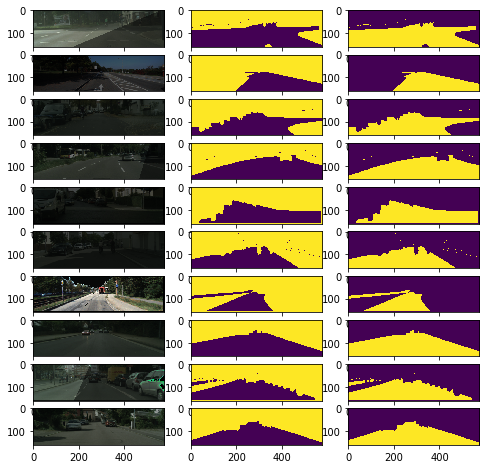

Debug: .\data\cityscapes\leftImg8bit\train\darmstadt\darmstadt_000073_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\jena\jena_000022_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\strasbourg\strasbourg_000000_018874_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\hamburg\hamburg_000000_069177_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\bremen\bremen_000246_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\dusseldorf\dusseldorf_000044_000019_leftImg8bit.png
Debug: .\data\data_road\training\image_2\um_000011.png
Debug: .\data\cityscapes\leftImg8bit\train\bremen\bremen_000111_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\tubingen\tubingen_000143_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\ulm\ulm_000066_000019_leftImg8bit.png


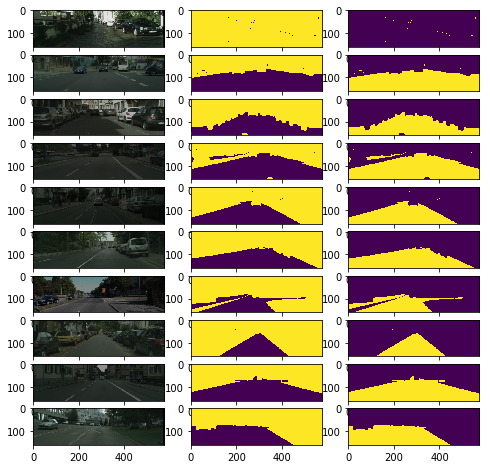

Debug: .\data\cityscapes\leftImg8bit\train\stuttgart\stuttgart_000041_000019_leftImg8bit.png
Debug: .\data\data_road\training\image_2\uu_000021.png
Debug: .\data\cityscapes\leftImg8bit\train\bochum\bochum_000000_037829_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\erfurt\erfurt_000061_000019_leftImg8bit.png
Debug: .\data\data_road\training\image_2\umm_000083.png
Debug: .\data\cityscapes\leftImg8bit\train\hanover\hanover_000000_001620_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\bremen\bremen_000194_000019_leftImg8bit.png
Debug: .\data\data_road\training\image_2\um_000048.png
Debug: .\data\cityscapes\leftImg8bit\train\tubingen\tubingen_000036_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\hamburg\hamburg_000000_069417_leftImg8bit.png


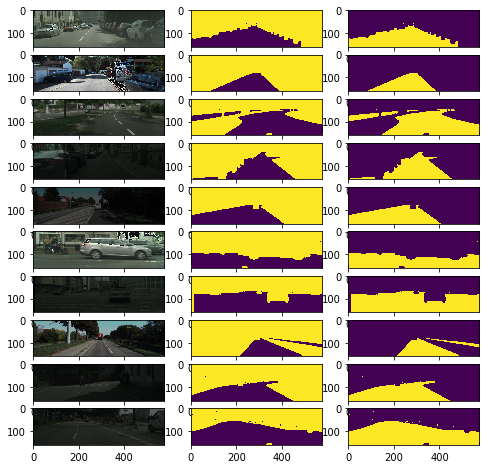

Debug: .\data\cityscapes\leftImg8bit\train\hanover\hanover_000000_024441_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\aachen\aachen_000121_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\dusseldorf\dusseldorf_000209_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\weimar\weimar_000054_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\monchengladbach\monchengladbach_000000_001294_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\stuttgart\stuttgart_000057_000019_leftImg8bit.png
Debug: .\data\data_road\training\image_2\uu_000010.png
Debug: .\data\cityscapes\leftImg8bit\train\hamburg\hamburg_000000_028056_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\aachen\aachen_000037_000019_leftImg8bit.png
Debug: .\data\cityscapes\leftImg8bit\train\krefeld\krefeld_000000_017489_leftImg8bit.png


KeyboardInterrupt: 

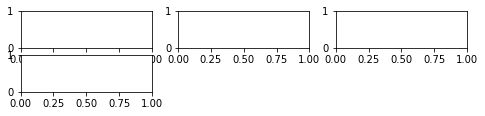

In [9]:
batch_size = 10
cnt = 0

for image, label in get_batches_fn(batch_size):
    f, axarr = plt.subplots(10, 3, figsize=(8,8))
    
    for i in range(batch_size):
        #print('Debug', image.shape, label.shape)
        
        axarr[i][0].imshow(image[i])
        axarr[i][1].imshow(label[i][:, :, 0])
        axarr[i][2].imshow(label[i][:, :, 1])
        
    plt.show()
    ++cnt
    
    if(cnt==2):
        break

# Optimize model for inference

In [28]:
import tensorflow as tf

# The original freeze_graph function
# from tensorflow.python.tools.freeze_graph import freeze_graph 


def freeze_graph(model_dir, output_node_names):
    """Extract the sub graph defined by the output nodes and convert 
    all its variables into constant 
    Args:
        model_dir: the root folder containing the checkpoint state file
        output_node_names: a string, containing all the output node's names, 
                            comma separated
    """
    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            "directory: %s" % model_dir)

    if not output_node_names:
        print("You need to supply the name of a node to --output_node_names.")
        return -1

    # We retrieve our checkpoint fullpath
    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path
    
    # We precise the file fullname of our freezed graph
    absolute_model_dir = "/".join(input_checkpoint.split(os.sep)[:-1])
    output_graph = absolute_model_dir + "/frozen_model.pb"

    # We clear devices to allow TensorFlow to control on which device it will load operations
    clear_devices = True

    # We start a session using a temporary fresh Graph
    with tf.Session(graph=tf.Graph()) as sess:
        # We import the meta graph in the current default Graph
        saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)

        # We restore the weights
        saver.restore(sess, input_checkpoint)
        

        # We use a built-in TF helper to export variables to constants
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess, # The session is used to retrieve the weights
            tf.get_default_graph().as_graph_def(), # The graph_def is used to retrieve the nodes 
            output_node_names.split(",") # The output node names are used to select the usefull nodes
        ) 

        print(output_graph)
        # Finally we serialize and dump the output graph to the filesystem
        with tf.gfile.GFile(output_graph, "wb") as f:
            f.write(output_graph_def.SerializeToString())
        print("%d ops in the final graph." % len(output_graph_def.node))

    return output_graph_def

freeze_graph(r'C:\GitProjects\CarND-Semantic-Segmentation\trained_model', 'logits')

INFO:tensorflow:Restoring parameters from C:\GitProjects\CarND-Semantic-Segmentation\trained_model\model.ckpt
INFO:tensorflow:Froze 42 variables.
Converted 42 variables to const ops.
C:/GitProjects/CarND-Semantic-Segmentation/trained_model/frozen_model.pb
248 ops in the final graph.


# Use optimize model to inference 

In [24]:
A= [[[3,3,3], [2,1,3], [1,1,1]]]
B=[2,1,3]
print(np.all(A==[1,1,1], axis=1))

AxisError: axis 1 is out of bounds for array of dimension 0